In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import digamma, gammaln
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

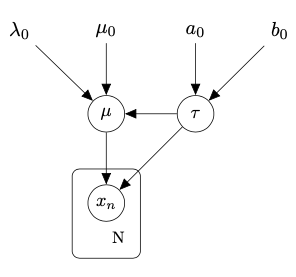

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [22]:
def generate_data(mu, tau, N):
  # Insert your code here

  # Calculate standard deviation from precision (sigma = 1 / sqrt(tau))
  sigma = np.sqrt(1 / tau)
  
  # Generate data
  D = np.random.normal(loc=mu, scale=sigma, size=N)
  
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



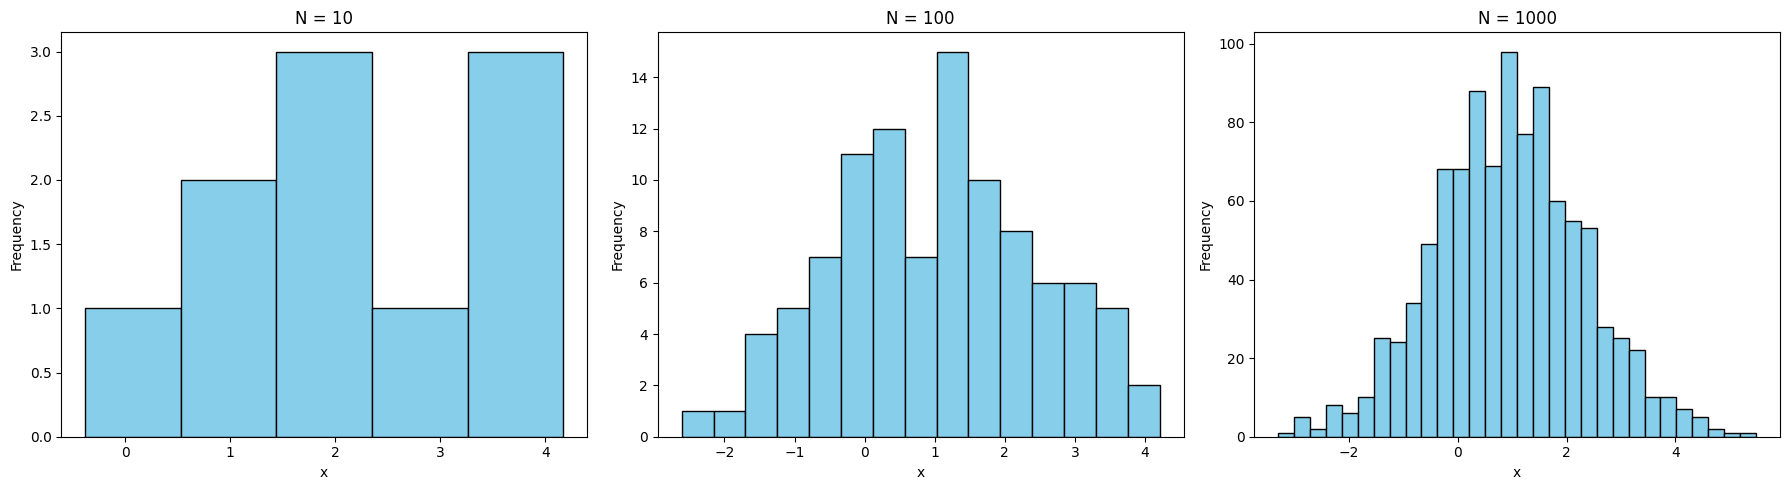

In [23]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visualize the datasets via histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Dataset 1 (N=10)
axes[0].hist(dataset_1, bins=5, color='skyblue', edgecolor='black')
axes[0].set_title('N = 10')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Frequency')

# Dataset 2 (N=100)
axes[1].hist(dataset_2, bins=15, color='skyblue', edgecolor='black')
axes[1].set_title('N = 100')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Frequency')

# Dataset 3 (N=1000)
axes[2].hist(dataset_3, bins=30, color='skyblue', edgecolor='black')
axes[2].set_title('N = 1000')
axes[2].set_xlabel('x')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [24]:
def ML_est(data):
  # ML estimate for mu is the sample mean
  mu_ml = np.mean(data)
  
  # ML estimate for variance is the sample variance (denominator N)
  # np.var(data) defaults to dividing by N, which is correct for ML.
  var_ml = np.var(data)
  
  # ML estimate for precision is the inverse of the ML variance
  tau_ml = 1 / var_ml
  
  return mu_ml, tau_ml

### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [25]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = len(D)
  mean_data = np.mean(D)
  
  # Calculate posterior parameters
  lambda_N = lambda_0 + N
  mu_N = (lambda_0 * mu_0 + N * mean_data) / lambda_N
  a_N = a_0 + N / 2
  
  # Calculate b_N term by term
  # Term 1: b_0
  # Term 2: 0.5 * sum of squared differences from the mean (sample variance * N)
  term2 = 0.5 * np.sum((D - mean_data)**2)
  # Term 3: Interaction term between prior mean and data mean
  term3 = (N * lambda_0 * (mean_data - mu_0)**2) / (2 * lambda_N)
  
  b_N = b_0 + term2 + term3
  
  return mu_N, lambda_N, a_N, b_N

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [26]:

# Prior parameters
mu_0 = 0.0
lambda_0 = 0.01  # Low precision implies high uncertainty about the mean
a_0 = 0.01       # Uninformative Gamma prior
b_0 = 0.01

Continue with a helper function that computes ELBO:


In [27]:
def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)
    
    # --- Expectations under q ---
    # E[tau] = a_N / b_N
    E_tau = a_N / b_N
    # E[ln tau] = psi(a_N) - ln(b_N)
    E_ln_tau = digamma(a_N) - np.log(b_N)
    
    # E_q[ (x - mu)^2 ] = sum( (x - mu_N)^2 + 1/lambda_N )
    term_data_diff = np.sum((D - mu_N)**2) + N / lambda_N
    
    # E_q[ (mu - mu_0)^2 ] = (mu_N - mu_0)^2 + 1/lambda_N
    term_prior_diff = (mu_N - mu_0)**2 + 1.0 / lambda_N

    # --- ELBO Terms ---
    
    # 1. E[ln p(X|mu, tau)]
    E_ln_p_X = (N / 2) * E_ln_tau - (N / 2) * np.log(2 * np.pi) - (E_tau / 2) * term_data_diff
    
    # 2. E[ln p(mu|tau)]
    E_ln_p_mu = 0.5 * np.log(lambda_0) + 0.5 * E_ln_tau - 0.5 * np.log(2 * np.pi) - (lambda_0 * E_tau / 2) * term_prior_diff
    
    # 3. E[ln p(tau)]
    E_ln_p_tau = a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_ln_tau - b_0 * E_tau
    
    # 4. E[ln q(mu)] (Negative Entropy of Gaussian)
    # Entropy H(q_mu) = 0.5 * (ln(2pi) + 1 - ln(lambda_N)) -> E[ln q] = -H
    E_ln_q_mu = -0.5 * np.log(2 * np.pi) + 0.5 * np.log(lambda_N) - 0.5
    
    # 5. E[ln q(tau)] (Negative Entropy of Gamma)
    E_ln_q_tau = a_N * np.log(b_N) - gammaln(a_N) + (a_N - 1) * E_ln_tau - b_N * E_tau
    
    # Total ELBO
    elbo = E_ln_p_X + E_ln_p_mu + E_ln_p_tau - E_ln_q_mu - E_ln_q_tau
    
    return elbo

Now, implement the CAVI algorithm:

In [28]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=50):
    N = len(D)
    x_bar = np.mean(D)
    
    # 1. Initialize variables
    
    # mu_N and a_N are determined solely by the data/prior in this specific model 
    # and do not change between iterations (see Bishop Eq 10.27 and 10.30)
    mu_N = (lambda_0 * mu_0 + N * x_bar) / (lambda_0 + N)
    a_N = a_0 + (N + 1) / 2
    
    # Initial guess for Expected value of tau
    E_tau = 1.0 
    
    elbos = []
    
    # 2. CAVI iterations
    for i in range(max_iter):
        # Update lambda_N (precision of q_mu) - depends on E[tau]
        lambda_N = (lambda_0 + N) * E_tau
        
        # Update b_N (rate of q_tau) - depends on E[mu^2] and E[mu] terms
        # We expand the expectation: E[ (x - mu)^2 ] + lambda_0 * E[ (mu - mu_0)^2 ]
        term_data = np.sum((D - mu_N)**2) + N / lambda_N
        term_prior = (mu_N - mu_0)**2 + 1.0 / lambda_N
        
        b_N = b_0 + 0.5 * (term_data + lambda_0 * term_prior)
        
        # Re-calculate E[tau] for the next iteration
        E_tau = a_N / b_N
        
        # Compute and store ELBO
        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)
        
    return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_19690/2275671609.py:53: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(M, T, Z_exact, colors='green', label='Exact Posterior')
/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_19690/2275671609.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(M, T, Z_vi, colors='blue', linestyles='dashed', label='Variational Approx')


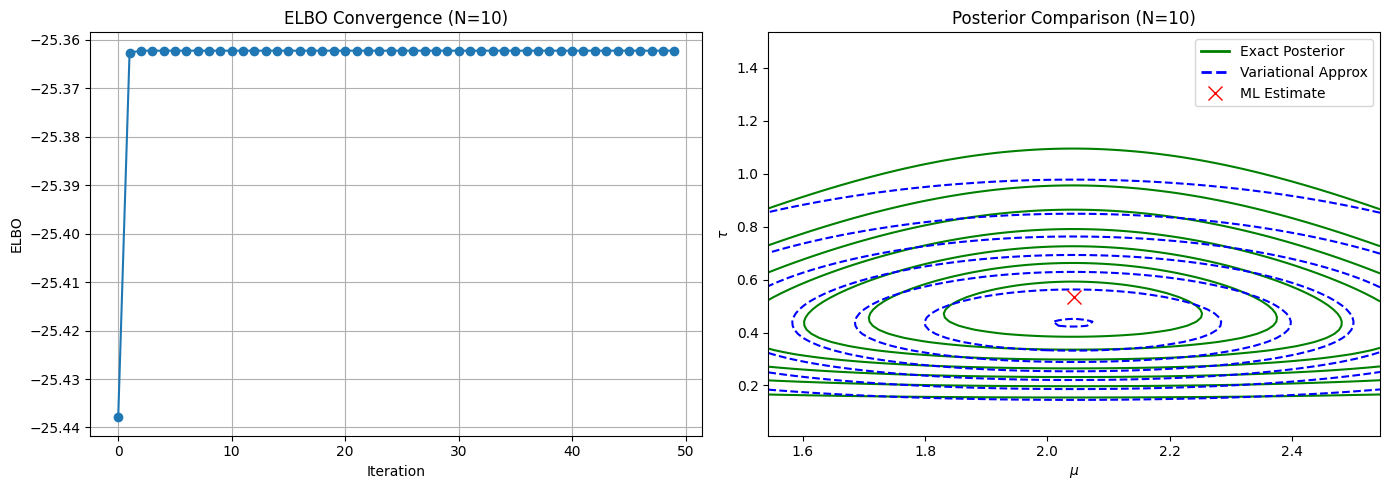

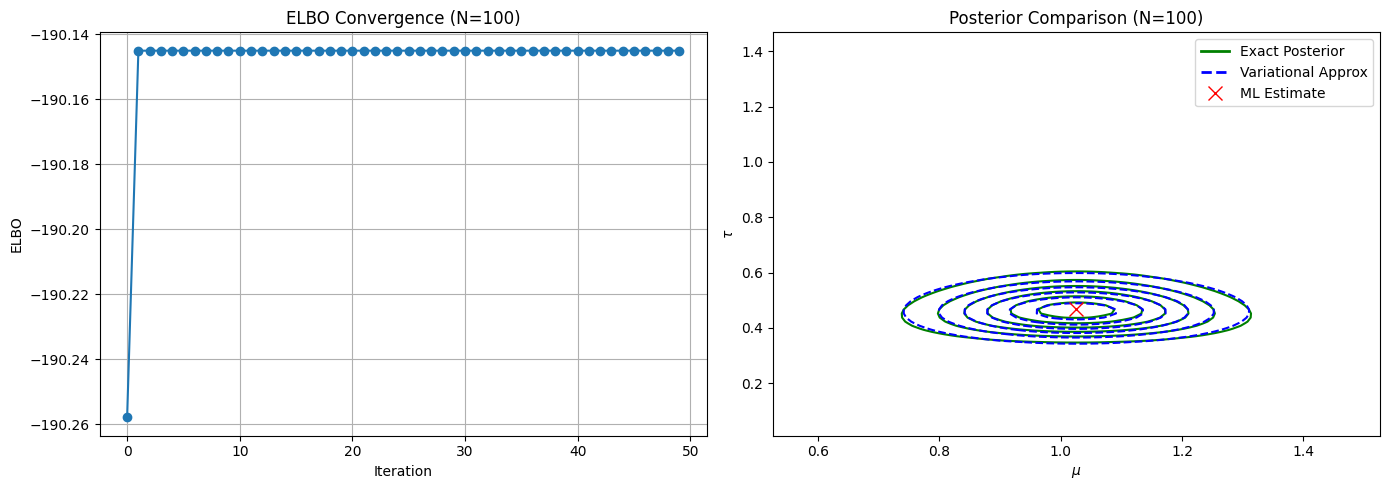

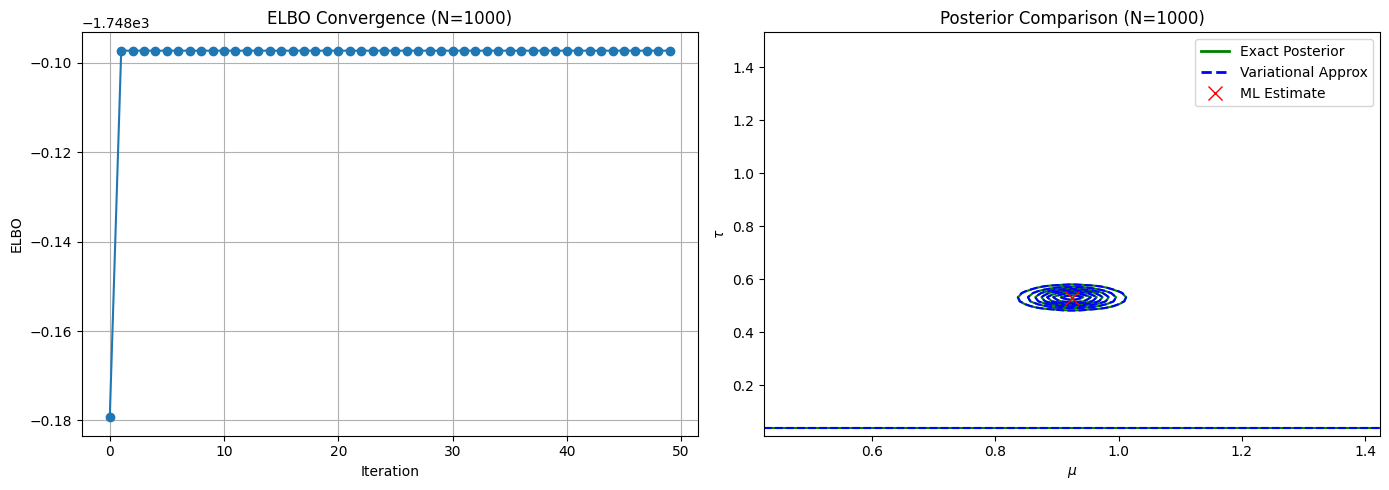

In [29]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot


def run_analysis_and_plot(dataset, title):
    # 1. Run CAVI
    a_N_vi, b_N_vi, mu_N_vi, lambda_N_vi, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0)
    
    # 2. Compute Exact Posterior (using your function from 1.3.11)
    mu_N_ex, lambda_N_ex, a_N_ex, b_N_ex = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)
    
    # 3. Compute ML Estimate (using your function from 1.3.10)
    mu_ml, tau_ml = ML_est(dataset)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot A: ELBO Convergence
    axes[0].plot(elbos, 'o-')
    axes[0].set_title(f'ELBO Convergence ({title})')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('ELBO')
    axes[0].grid(True)
    
    # Plot B: Contour Comparison
    # Create grid centered around the ML estimate
    mu_range = np.linspace(mu_ml - 0.5, mu_ml + 0.5, 100)
    tau_range = np.linspace(max(0.01, tau_ml - 1.0), tau_ml + 1.0, 100)
    M, T = np.meshgrid(mu_range, tau_range)
    
    # Exact Posterior Density (Normal-Gamma)
    # p(mu, tau) = Gamma(tau|a,b) * Normal(mu|mu_n, 1/(lambda_n * tau))
    pdf_tau_ex = gamma.pdf(T, a_N_ex, scale=1/b_N_ex)
    sigma_ex = 1 / np.sqrt(lambda_N_ex * T)
    pdf_mu_ex = norm.pdf(M, loc=mu_N_ex, scale=sigma_ex)
    Z_exact = pdf_tau_ex * pdf_mu_ex
    
    # Variational Approximation (Factorized)
    # q(mu, tau) = Gamma(tau|a,b) * Normal(mu|mu_n, 1/lambda_n)
    pdf_tau_vi = gamma.pdf(T, a_N_vi, scale=1/b_N_vi)
    sigma_vi = 1 / np.sqrt(lambda_N_vi) # Note: Independent of T here
    pdf_mu_vi = norm.pdf(M, loc=mu_N_vi, scale=sigma_vi)
    Z_vi = pdf_tau_vi * pdf_mu_vi
    
    # Contours
    axes[1].contour(M, T, Z_exact, colors='green', label='Exact Posterior')
    axes[1].contour(M, T, Z_vi, colors='blue', linestyles='dashed', label='Variational Approx')
    axes[1].plot(mu_ml, tau_ml, 'rx', markersize=10, label='ML Estimate')
    
    axes[1].set_title(f'Posterior Comparison ({title})')
    axes[1].set_xlabel(r'$\mu$')
    axes[1].set_ylabel(r'$\tau$')
    
    # Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='green', lw=2, label='Exact Posterior'),
                       Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='Variational Approx'),
                       Line2D([0], [0], color='red', marker='x', lw=0, markersize=10, label='ML Estimate')]
    axes[1].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

# Run analysis for all three datasets
run_analysis_and_plot(dataset_1, "N=10")
run_analysis_and_plot(dataset_2, "N=100")
run_analysis_and_plot(dataset_3, "N=1000")